# Overview of Electricity Generation in the USA based on EIA data

The following is an exercise in using data from the Electricity Information Agency (EIA),
to famialarize myself with both the broad state of the US electrical grid, as well as some elementary data science.

I have converted the bulk data file from (url_here) to a local SQL database.  I used Psycopg2 for direct SQL interaction with that PostGRESQL database.  
I can then efficiently select data from that database, based on geographic region and type of generation.  (While the data should nominally fit into memory in one Pandas dataframe, I found that my computer ran out of memory before it could be loaded.)  

The resulting queries from SQL can then be converted into a Pandas dataframe.  Since the data is of the form
"[[date1,number1],[date2,number]...], as one long string, this is converted into a list, then a Numpy array.
The first column is used to generate a Pandas PeriodIndex (which is then further converted to a DateTimeIndex for plotting reasons).  The second column is then indexed.  The resulting series is output as the elements of a list of series for the desired state, and generation type.  
These results can then be plotted using basic Matplotlib.

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
import psycopg2
import datetime 
import matplotlib.pyplot as pl
from psycopg2 import sql

from sql_lib import create_conn_and_cur

In [2]:
#Set up connections to SQL database, which was generated from the bulk JSON file.
database_name='US_ELEC'
fname='ELEC'
table_name=fname
engine=sqlalchemy.create_engine("postgresql+psycopg2://localhost/"+database_name)

#make connection to database (which is needed by Pandas), 
# and the cursor which actually executes SQL commands.
conn=psycopg2.connect(dbname=database_name,host='localhost')
conn.set_session(autocommit=True)
cur = conn.cursor()


The following defines some useful functions for grabbing SQL queries, and loading the desired columns into a Pandas DataFrame.

In [3]:
#make safe SQL queries, with deired list of columns in "out_columns".
#Assume we are searching through name for entries with desired type of series, for particular states,
#as well as generation type.
def safe_sql_query(table_name,
                   out_columns,
                   series_type='Net generation', 
                   state='Oregon',
                   gen_type='all',
                   freq='M'):
    #make up categories to match the name by. 
    query_match_list=list()
    l1 = sql.Literal(series_type+' :%')
    l2 = sql.Literal('%: '+state+' :%')
    l3 = sql.Literal('%'+gen_type+'%')
    #join together these matches with ANDs to match them all
    like_query=sql.SQL(' AND name LIKE ').join([l1,l2,l3])

    #Total SQL query to select desired columns with features 
    q1 = sql.SQL("SELECT {} FROM {} WHERE (name LIKE {} AND f LIKE {}) ").format(
                sql.SQL(' ,').join(map(sql.Identifier,out_columns)),
                sql.Identifier(table_name),
                like_query,
                sql.Literal(freq))

    return(q1)

#Get a dataframe from SQL database for given psycopg2 cursor,
#with desired output columns.     
#Must select data based on series type, state, and type of generation.
def get_dataframe(cur,
                  out_columns,
                  table="ELEC",
                  series_type='Net Generation',
                  state='Oregon',
                  gen_type='solar',
                  freq='M'):
    q = safe_sql_query(table,out_columns,series_type,state,gen_type,freq)
    cur.execute(q);
    df0=cur.fetchall();
    df = pd.DataFrame(df0,columns=out_columns);
    return df


In [26]:
#Initial readin of SQL dataframes returns 'data' as a string of a list of lists.  
#This function goes row by row, converting that 'data' column
#into a new series, with datetimeindex in 'data2'

def convert_df(df):
    Nrows=len(df)
# df['data2']=pd.Series()
    data_array=[];
    for i in range(0,Nrows):
        #check there's actually data there.
        print('Making',i,'dataset')
        #use next line since the read in dataframe has returned a string.
        init_series=np.asarray(eval(df.loc[i,'data']))
        dat2=init_series[:,1];
        timeindex=make_timeindex(df.loc[i])
        if (len(dat2) != len(timeindex)):
            print('Unequal lengths')
            print(len(dat2),len(timeindex))
        else:
            s=pd.Series(dat2,index=timeindex)
            data_array.append(s)

        return data_array

    
# Make a Period Index - really, really easy.
#But plotting is limited with "Periods".  It seems only
#"DateTimeIndices" allow easy combinations.  
def convert_df_period(df):
    Nrows=len(df)
# df['data2']=pd.Series()
    data_array=[];
    for i in range(0,Nrows):
        #check there's actually data there.
        print('Making',i,'dataset')
        #use next line since the read in dataframe has returned a string.
        init_series=np.asarray(eval(df.loc[i,'data']))
        dat2=init_series[:,1];
        f = df.loc[i,'f']
        periodindex=pd.PeriodIndex(init_series[:,0],freq=f)
        s=pd.Series(dat2,index=periodindex)
        data_array.append(s.to_timestamp())

    return data_array

In [60]:
# q=safe_sql_query(table_name="ELEC",out_columns=('name','series_id'),gen_type='solar')
# print(q.as_string(conn))
# cur.execute(q)

#Try to select data from fields with names such as net generation and desired state.
#Possibly also by electricity source.  Nuclear/Solar/Wind/Gas/Coal etc.  

#Useful fields: Net Generation : state : type
#Also interesting: Average retail price of electricity.  
#Net generation
#Retail sales of electricity
#Revenue

#Can Identify useful tags by splitting at colons":"
out_col=('name','data','start','end','f')
df=get_dataframe(cur,out_col,series_type='Net generation',state='United States',gen_type='nuclear');
len(df)
d0=convert_df_period(df)


Making 0 dataset
Making 1 dataset
Making 2 dataset
Making 3 dataset
Making 4 dataset


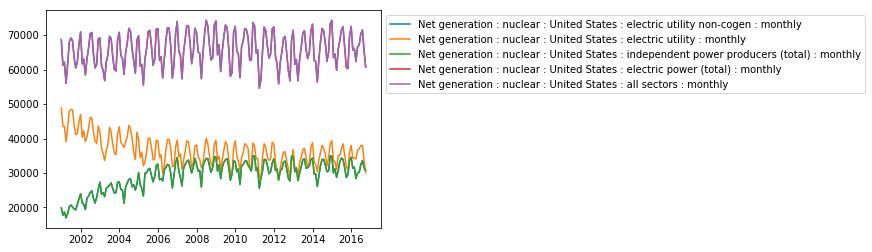

In [63]:
for i in range(0,len(d0)):
    pl.plot(d0[i],label=df.loc[i,'name'])
pl.legend(loc='upper left',bbox_to_anchor=(1,1))
pl.show()

Finally (months after I first wanted to do this), we can start looking at some data.  
I would like to review the sources of electricity to get a sense of seasonal variations (in terms of availability and use).  For example, I'd expect solar generation to be largest in summer, lowest in winter.  
I would assume this varies geographically.  I'll assume the seasonality can be averaged over by using the annual data. 

Residential Use will be largest in winter, barring the occasional fluctuation in summer.  

The purpose of this survey is to identify the scale of renewables in the market.  
How large a share do renewables (solar, hydro, wind) take up?  How does this vary regionally?  Over time? 
Who are the primary users of electricity?  
I'll assume the base load is provided by coal, gas and nuclear plants.  


Ultimately however, I intend to try my hand at some machine learning projects relevant to electricity.  
The first project involves demand forecasting.  The other place where data science (and nifty math) may have a role in this, is on the market.  While I am comfortable with stochastic calculus etc, I would need to learn about options pricing
and the relevant techniques for this sector of the energy market.

This is meant to be a brief background piece for that.  Since we are forecasting a time series,
I aim to use TensorFlow with some form of neural network (perhaps recurrent) to try forecasting.
Ideally, I would cross-reference the electricity data sets against the published weather forecasts for a given day.  
The model should be able to predict demand given the location, time of year, and weather forecast.  (This is probably the 
simplest thing available)

From a smart-grid perspective, how can randomly fluctuating sources, such as solar and wind, be included 
in supplying power to the grid?  